In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from eikonax import corefunctions, derivator, logging, preprocessing, solver, tensorfield

sns.set_theme(style="ticks")

In [2]:
disable_jit = False
log_compiles = False
mesh_bounds_x = (0, 1)
mesh_bounds_y = (0, 1)
num_points_x = 10
num_points_y = 10
dimension = 2

solver_data = solver.SolverData(
    tolerance=1e-6,
    max_num_iterations=1000,
    loop_type="jitted_while",
    max_value=1000,
    use_soft_update=False,
    softminmax_order=20,
    softminmax_cutoff=1,
    log_interval=1,
)

derivator_data = derivator.PartialDerivatorData(
    softmin_order=20,
    softminmax_order=20,
    softminmax_cutoff=1,
)

logger_data = logging.LoggerSettings(
    log_to_console=True,
    logfile_path=None,
)

initial_sites = corefunctions.InitialSites(
    inds=jnp.array((0,), dtype=jnp.int32), values=jnp.array((0,), dtype=jnp.float32)
)

In [3]:
vertices, simplices = preprocessing.create_test_mesh(
    mesh_bounds_x, mesh_bounds_y, num_points_x, num_points_y
)
adjacency_data = preprocessing.get_adjacent_vertex_data(simplices, vertices.shape[0])
vertices = jnp.array(vertices, dtype=jnp.float32)
simplices = jnp.array(simplices, dtype=jnp.int32)
adjacency_data = jnp.array(adjacency_data, dtype=jnp.int32)

mesh_data = corefunctions.MeshData(vertices=vertices, adjacency_data=adjacency_data)
parameter_vector = jnp.ones(simplices.shape[0], dtype=jnp.float32)
tensor_on_simplex = tensorfield.LinearScalarSimplexTensor(dimension)
tensor_field_mapping = tensorfield.LinearScalarMap()
tensor_field = tensorfield.TensorField(simplices.shape[0], tensor_field_mapping, tensor_on_simplex)
logger = logging.Logger(logger_data)

In [4]:
with jax.disable_jit(disable_jit), jax.log_compiles(log_compiles):
    parameter_field = tensor_field.assemble_field(parameter_vector)
    eikonal_solver = solver.Solver(mesh_data, solver_data, initial_sites, logger)
    solution = eikonal_solver.run(parameter_field)

In [5]:
with jax.disable_jit(disable_jit), jax.log_compiles(log_compiles):
    eikonax_derivator = derivator.PartialDerivator(mesh_data, derivator_data, initial_sites)
    sparse_partial_solution, sparse_partial_tensor = eikonax_derivator.compute_partial_derivatives(
        solution.values, parameter_field
    )
    derivative_solver = derivator.DerivativeSolver(solution.values, sparse_partial_solution)
    sparse_partial_parameter = tensor_field.assemble_jacobian(
        num_points_x * num_points_y, sparse_partial_tensor, parameter_vector
    )

In [6]:
rhs_adjoint_equation = np.ones(solution.values.shape, dtype=jnp.float32)
adjoint_variable = derivative_solver.solve(rhs_adjoint_equation)
gradient = sparse_partial_parameter.T @ adjoint_variable

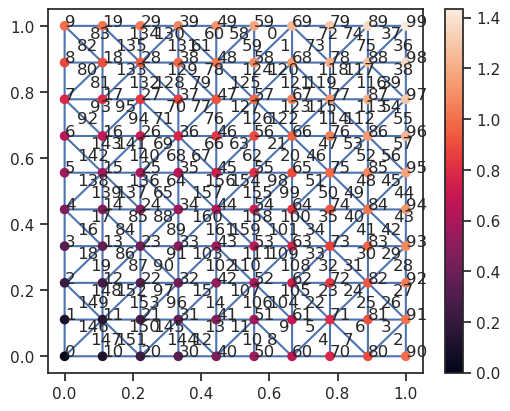

In [7]:
fig, ax = plt.subplots(figsize=(5, 4), layout="constrained")
ax.triplot(vertices[:, 0], vertices[:, 1], simplices)
scatter_plot = ax.scatter(vertices[:, 0], vertices[:, 1], c=solution.values)
plt.colorbar(scatter_plot)
for i, vertex in enumerate(vertices):
    ax.annotate(i, (vertex[0], vertex[1]))
for i, simplex in enumerate(simplices):
    centroid = jnp.mean(vertices[simplex], axis=0)
    ax.annotate(i, (centroid[0], centroid[1]))